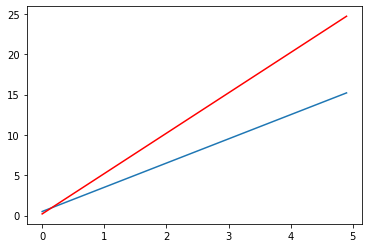

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

X=np.arange(0,5,0.1)
Y_obs=np.zeros(len(X))

for i in np.arange(len(X)):  
    Y_obs[i]= 5*X[i]+0.2  #you can add some noise
    
def toyModel(x,X):
    Y=np.zeros(len(X))
    for i in range(len(X)):  
        Y[i]=x[0]*X[i]+x[1]  # you can add some noise if you want
        
    return Y


#Range of a and b is given below

#2 <= a <= 10
#0.1= b <= 2

Y = toyModel([3,0.5],X)
plt.plot(X,Y)
plt.plot(X,Y_obs,'r')

# simple Kalman

In [5]:
def Kalman(Xb,Y,H,B,R,HXb): #booleen=0 garde la trace
    # xb: priori, Y: observation, H: obs. matrix, B: priori estimate uncertainty
    # R: Measurement uncertainty
    # need to linerize your function H here
    Xb.shape = (-1,1)
    Y.shape = (-1,1)
    HXb.shape = (-1,1)
    K=np.dot(B,np.dot(H.T,float(np.dot(H,np.dot(B,H.T))+R)**(-1))) 
    Xa=Xb + K.reshape(-1,1)*float(Y-HXb)
    return Xa

In [6]:
X=np.arange(0,5,0.1)
Xb = [3,0.5] # initialize

Y_traj_EnKF = []

for i in range(len(X)):
  H = np.array([X[i],1])
  HXb = toyModel(Xb,[X[i]])
  Xa=Kalman(np.array(Xb),np.array([Y_obs[i]]),H,np.eye(2),np.eye(1),HXb)
  Xb = Xa
  Y_traj_EnKF.append(float(toyModel(Xa,[X[i]])))

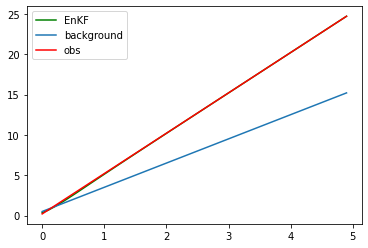

In [8]:
Y = toyModel([3,0.5],X)
plt.plot(X,Y_traj_EnKF,'g',label = 'EnKF')
plt.plot(X,Y,label = 'background')
plt.plot(X,Y_obs,'r',label = 'obs')
plt.legend()

#Ensemble Kalman

In [16]:
ens_size = 20
Xb_ens = np.random.multivariate_normal(np.array([3,0.5]), 0.2*np.eye(2),ens_size)
print(Xb_ens)

[[ 3.05918342  0.71371833]
 [ 3.20032483  0.27157907]
 [ 3.59090189  0.53828507]
 [ 2.81822351 -0.15647981]
 [ 2.62212211  0.34991054]
 [ 2.80095532 -0.39264619]
 [ 2.88021553  1.49098591]
 [ 2.42710056  1.2076732 ]
 [ 3.35519383  0.30551958]
 [ 2.65285248  0.10516254]
 [ 2.94497716  1.27659303]
 [ 2.12125301  0.09904053]
 [ 2.7428974   1.17874046]
 [ 2.33924602  0.06642256]
 [ 2.99907627 -0.56019592]
 [ 2.72012069  1.10147557]
 [ 3.5469766   0.14288159]
 [ 2.89315214  1.07970298]
 [ 3.13012215  0.09122054]
 [ 3.27821985  1.1053699 ]]


In [38]:
X=np.arange(0,5,0.1)
Xa_ens = np.copy(Xb_ens)

def toyModel(x,X):
    Y=np.zeros(len(X))
    for i in range(len(X)):  
        Y[i]=x[0]*X[i]+x[1] 
    return Y

Y_traj_EnKF = []

for i in range(len(X)):
  B = np.cov( Xb_ens.T)
  for j in range(ens_size):
    Xb = Xb_ens[j,:].reshape(-1,1)
    H = np.array([X[i],1])
    HXb = toyModel(Xb,[X[i]])
    Xa=Kalman(np.array(Xb),np.array([Y_obs[i] ]),H,np.eye(2),0.01*np.eye(1),HXb)
    Xa_ens[j,:] = Xa.ravel()
  Xa = np.mean(Xa_ens,axis = 0)
  Y_traj_EnKF.append(float(toyModel(Xa,[X[i]])))

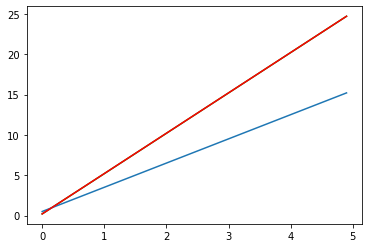

In [39]:
Y = toyModel([3,0.5],X)
plt.plot(X,Y_traj_EnKF,'g')
plt.plot(X,Y)
plt.plot(X,Y_obs,'r')

In [ ]:
def toyModel(x,X):
    Y=np.zeros(len(X))
    for i in range(len(X)):  
        Y[i]=x[0]*X[i]+x[1]+ np.random.normal(0, 0.1)   
    return Y


# Variational

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


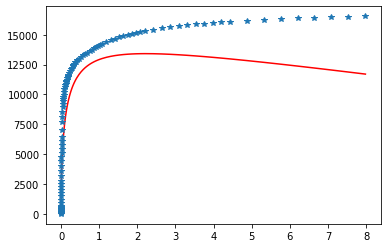

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file = pd.read_excel (r'drive/MyDrive/Kumar/Book1.xlsx', "Sheet1")
X= (file['X']).values.tolist()
Y= (file['Y']).values.tolist()

X_obs=np.array(X)
Y_obs=np.array(Y)*10

#function to estimate Y with given k and n (to be assimilated), X (given displacement)


def forcastModel(k,n,xu_bar,yu_bar,x_norm,y_norm, X_obs):
    Y=np.zeros(len(X_obs))
    D= 10
    a=1-2*n
    x_bar=X_obs*x_norm
    b=2*n*(x_bar)/xu_bar - (1-n)*(1+(x_bar*k/yu_bar))
    c=x_bar*k/yu_bar*(1-n)-n*x_bar*x_bar/(xu_bar*xu_bar)
    
    for i in np.arange(len(X_obs)):  
        Y[i]=y_norm*(yu_bar*((2*c[i])/(-b[i]+math.sqrt(max(0,b[i]*b[i]-4*a*c[i])))))
    return Y


#My initial guess for the parameters
# 4 <= k <= 12
# 0 <= n <= 1
# xu_bar > yu_bar/k


#I know below guess is bad, but I can confirm the parameters after discussing with the experiment guys onl 
# 100 <=xu_bar <= 500  y
# 5 <= yu_bar <= 15
# 70 <= x_norm <= 120
# 800 <= y_norm <= 1500



#trial run with given n,k,xu_bar,yu_bar,x_norm,y_norm
Y = forcastModel(8,0.9,200,11,90,1220,X_obs)
plt.plot(X_obs,Y,'r') #from forcast model
plt.plot(X_obs,Y_obs,'*') #Corrected observation

In [ ]:
!pip install smt
!pip install adao

In [ ]:
from smt.sampling_methods import LHS
from adao import adaoBuilder
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
x_b = np.array([8,0.9,200,11,90,1220])

Var_traj = []

#for i in range(11,len(X_obs)):
for i in range(11,86):
  print('step',i)
  Y_current_obs=Y_obs[10:i]
  def f(x):
    return forcastModel(x[0],x[1],x[2],x[3],x[4],x[5], X_obs[10:i])
  diag_B = np.ones(Y_current_obs.size)
  if Y_current_obs.size>= 10:
    diag_B[-10:-1] = np.ones(9) * 0.1

  case = adaoBuilder.New()
  case.set( 'AlgorithmParameters', Algorithm='3DVAR',
            Parameters = {"Minimizer" : "LBFGSB","MaximumNumberOfSteps":100,
                          "Bounds":[[4,12],[0,1],[100,500],[5,15],[70,120],[800,1500]],
                        # "CostDecrementTolerance":1.e-5,
                          "StoreSupplementaryCalculations":["CostFunctionJ","CurrentState",
                          "SimulatedObservationAtOptimum",
                          "SimulatedObservationAtBackground",
                          "JacobianMatrixAtBackground",
                          "JacobianMatrixAtOptimum",
                          "KalmanGainAtOptimum",
                          "APosterioriCovariance"]
                          } )
  case.set( 'Background',          Vector=x_b)
  case.set( 'BackgroundError',     ScalarSparseMatrix=1000.0 )
  case.set( 'Observation',         Vector=Y_current_obs )
  case.set( 'ObservationError',    Matrix = np.diag(diag_B) )
  case.set( 'ObservationOperator', OneFunction = f)

  case.execute()

  x_a = case.get("Analysis")[-1]
  x_b = x_a

  Var_traj.append(f(x_a)[-1])


step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85


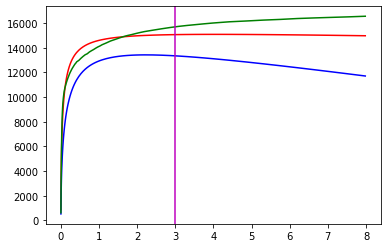

In [ ]:
X= (file['X']).values.tolist()
x_b = np.array([8,0.9,200,11,90,1220])
def f(x):
  return forcastModel(x[0],x[1],x[2],x[3],x[4],x[5], X_obs[10:])

plt.plot(X[10:],f(x_a),'r',label = 'analysis')
plt.plot(X[10:],f(x_b),'b',label = 'background')
plt.plot(X[10:],np.array(Y_obs)[10:],'g',label = 'obs')
plt.axvline(x=3.,color='m')

# Particle Filter

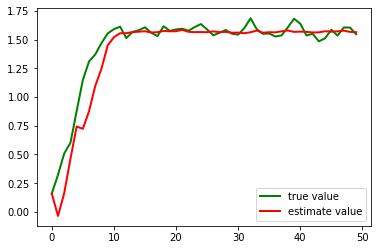

In [42]:


import numpy as np
import matplotlib.pyplot as plt


def estimate(particles, weights):
    mean = np.average(particles, weights=weights)
    var = np.average((particles - mean) ** 2, weights=weights)
    return mean, var


def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  
    rn = np.random.rand(N)
    indexes = np.searchsorted(cumulative_sum, rn)
    # resampling stage
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    return particles, weights


x = np.random.normal(0,1)  # initial value
t = 20
T = 50  # number of time steps
dt = t/T
x_N = 0.1*dt  # system covariance
x_R = 1*dt  # observation covariance
N = 100  # number of particles 

V = 1  # initial variance
x_P = x + np.random.normal(0,V,N)
x_P_out = [x_P]


z_out = [dt * x ** 3  + np.random.normal(0,x_R)]  # observations
x_out = [x]  
x_est = x  
x_est_out = [x_est]


for t in range(1, T):
    x = x + dt * x * np.cos(x) + np.random.normal(0,x_N) # dynamical model
    z = dt * x ** 3 + np.random.normal(0,x_R)
    # updating particles 
    x_P_update = x_P + dt * x_P * np.cos(x_P) + np.random.normal(0,x_N,N)
    z_update = dt * x_P_update ** 3 

    P_w = (1 / np.sqrt(2 * np.pi * x_R)) * np.exp(-(z - z_update) ** 2 / (2 * x_R))
    P_w /= np.sum(P_w)

    x_est, var = estimate(x_P_update, P_w)
    # resampling
    #x_P, P_w = x_P_update, P_w
    x_P, P_w = simple_resample(x_P_update, P_w)

    x_out.append(x)
    z_out.append(z)
    x_est_out.append(x_est)
    x_P_out.append(x_P)

t = np.arange(0, T)
x_P_out = np.array(x_P_out)


plt.plot(t, x_out, color='g', linewidth=2, label='true value')
plt.plot(t, x_est_out, color='red', linewidth=2, label='estimate value')
plt.legend()
plt.show()